# ML-Exercise 2

This notebook contains the second exercise of the Machine Learning for Visual Computing (183.605) lecture at TU Wien. Assignment via TUWEL. Please be aware of the deadlines in TUWEL.

* Upload a zip-file with the required programms. The programming language is python.
    1. Gaussian Process --> `solutions/gaussian_process.py`
    3. Vision Transformer --> `solutions/vision_transformer.py`
* If you needed additional conda or pip packages add an anaconda environment.yml to the zip-file
    1. conda env export > environment.yml
    2. See --> https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment

## Settings

In [9]:
NUM_SAMPLES = 2500
VALID_RATIO = 0.9
BATCH_SIZE = 4096
EPOCHS_SLP = 100
EPOCHS_MLP = 50

LR_SLP = 0.5
LR_MLP = 0.001

## Imports

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import cv2
from numba import jit
import pandas as pd
from tqdm import tqdm, trange
import math
import torch.optim as optim
from torchinfo import summary
from torch import nn
np.set_printoptions(suppress=True)

!nvidia-smi

os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Jan  9 20:18:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:1D:00.0  On |                  N/A |
| 33%   38C    P0    23W / 130W |   1854MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generate and prepare data

In [11]:
from util.generate_dataset import make_dataset

In [12]:
dataset, labels = make_dataset(int(NUM_SAMPLES/2))
print(dataset.shape, labels.shape)
dataset_train = dataset[:int(NUM_SAMPLES*0.8)]
labels_train = labels[:int(NUM_SAMPLES*0.8)]

dataset_val = dataset[int(NUM_SAMPLES*0.8):]
labels_val = labels[int(NUM_SAMPLES*0.8):]

print(dataset_train.shape, labels_train.shape, dataset_val.shape, labels_val.shape)

(2500, 16384) (2500,)
(2000, 16384) (2000,) (500, 16384) (500,)


## Gaussian Processes

In [13]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)
#

In [14]:
from util.gaussian_process_util import plot_gp_results, exponentiated_quadratic
from solutions.gaussian_process import gaussian_process, gaussian_process_noise
from sklearn.gaussian_process.kernels import *

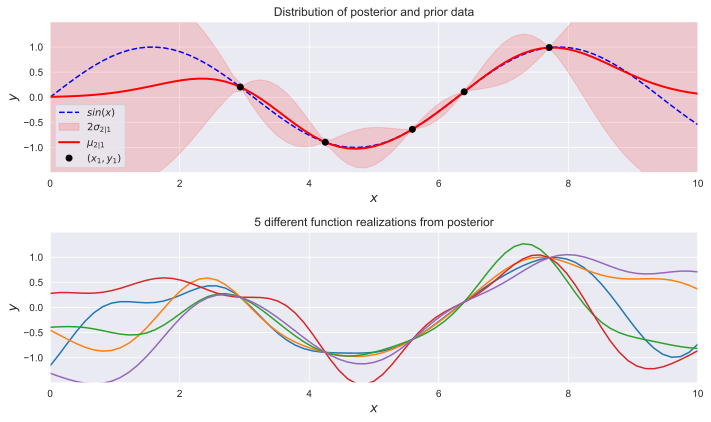

In [15]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 5  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (0, 10)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, covariance2 = gaussian_process(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
sigma2 = np.sqrt(np.diag(covariance2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=covariance2, size=ny)

plot_gp_results(f_sin, X1, X2, y1, y2, domain, μ2, sigma2)

<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Kernel of the observations.</span>.
![h](img/cov11.svg)

#### <span style="color:blue"> Kernel of observations vs to-predict.</span>.
![h](img/cov12.svg)

#### <span style="color:blue"> Predictions Gaussian Process.</span>.
![h](img/gp_output.svg)

Error: 4.370368308963569


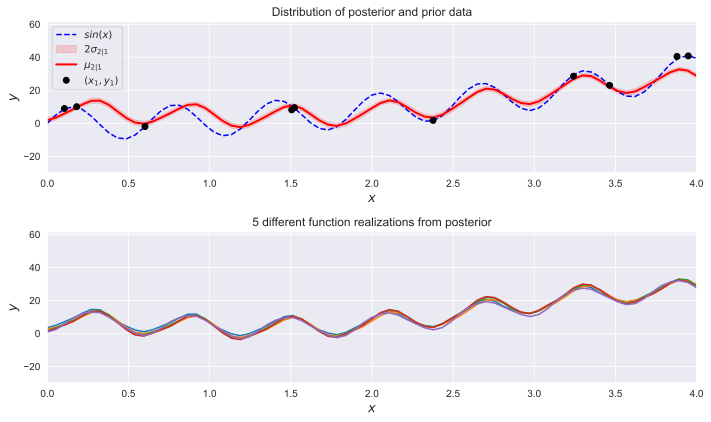

In [16]:
# Compute the posterior mean and covariance
f_sin = lambda x: (2*x*x+(10*np.sin(10*x))).flatten()

n1 = 10  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (0, 4)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0], domain[1], size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

sigma_noise = 1.  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((sigma_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, covariance2 = gaussian_process_noise(X1, y1, X2, RBF() + ExpSineSquared(periodicity=0.6), n1, sigma_noise)
# Compute the standard deviation at the test points to be plotted
sigma2 = np.sqrt(np.diag(covariance2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=covariance2, size=ny)

# We want an Error of less than 5.
print("Error:", np.mean(np.abs(μ2 - f_sin(X2))))

plot_gp_results(f_sin, X1, X2, y1, y2, domain, μ2, sigma2)

<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Kernel of the observations (noisy).</span>.
![h](img/cov11.svg)

#### <span style="color:blue"> Kernel of observations vs to-predict (noisy).</span>.
![h](img/cov12.svg)

#### <span style="color:blue"> Prediction Gaussian Process (noisy).</span>.
![h](img/gp_noise_output.svg)

## Convert Dataset to PyTorch

In [6]:
NUM_SAMPLES = 10000

In [27]:
from util.vision_transformer_util import CircleSquareDataset
from torch.utils import data

In [28]:
dataset, labels = make_dataset(int(NUM_SAMPLES/2))
print(dataset.shape, labels.shape)
dataset_train = dataset[:int(NUM_SAMPLES*0.8)]
labels_train = labels[:int(NUM_SAMPLES*0.8)]

dataset_val = dataset[int(NUM_SAMPLES*0.8):]
labels_val = labels[int(NUM_SAMPLES*0.8):]

print(dataset_train.shape, labels_train.shape, dataset_val.shape, labels_val.shape)

dataset_pytorch = CircleSquareDataset(dataset_train, labels_train)

n_train_examples = int(len(dataset_pytorch) * VALID_RATIO)
n_valid_examples = len(dataset_pytorch) - n_train_examples

train_data, valid_data = data.random_split(dataset_pytorch, [n_train_examples, n_valid_examples])

print(len(train_data), len(valid_data))

train_dataloader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_dataloader = data.DataLoader(valid_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

(10000, 16384) (10000,)
(8000, 16384) (8000,) (2000, 16384) (2000,)
7200 800


## Transformer (Encoder - Decoder)

In [29]:
from solutions.vision_transformer import ViT
from util.vision_transformer_util import bcolors
import torch

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [4096, 1]                 288
├─Sequential: 1-1                                  [4096, 16, 16]            --
│    └─Rearrange: 2-1                              [4096, 16, 48]            --
│    └─Linear: 2-2                                 [4096, 16, 16]            784
├─Transformer: 1-2                                 [4096, 17, 16]            --
│    └─ModuleList: 2-3                             --                        --
│    │    └─ModuleList: 3-1                        --                        18,592
│    │    └─ModuleList: 3-2                        --                        18,592
├─Identity: 1-3                                    [4096, 16]                --
├─Sequential: 1-4                                  [4096, 1]                 --
│    └─LayerNorm: 2-4                              [4096, 16]                32
│    └─Linear: 2-5       

100%|██████████| 75/75 [01:53<00:00,  1.52s/it]


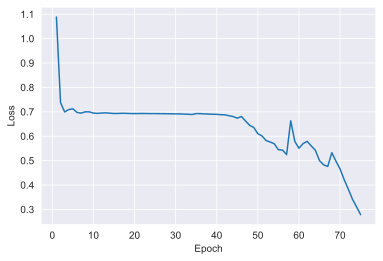

In [30]:
# We check if a GPU is available and use it. To force CPU set: device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transf = ViT(image_size = 16,
    patch_size = 4,
    num_classes = 1, # We don't predict classes
    dim = 16,
    depth = 2,
    heads = 4,
    mlp_dim = 64)

# Convert transformer to selected device
transf = transf.to(device)

transf.train()

print(summary(transf, input_size=(BATCH_SIZE,3, 16, 16)))

criterion = nn.BCELoss()
optimizer = optim.AdamW(transf.parameters(), lr=0.05)
loss_per_epoch = []
for epoch in trange(75):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (data, label) in enumerate(train_dataloader, 0):

        # Convert data and label (target in lecture) to selected device
        data = data.to(device)
        label = label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = transf(data).squeeze()
    
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    loss_per_epoch.append(running_loss/len(train_dataloader))
    
plt.plot(np.arange(len(loss_per_epoch))+1, loss_per_epoch)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


<div style="background-color:rgba(255, 255, 255, 1); text-align:center; vertical-align: middle; padding:40px 0;">

#### <span style="color:blue"> Potential transformer loss.</span>.
![h](img/transformer_loss_1.svg)

In [32]:
data_frame, acc = transf.predict(val_dataloader, device)
print(data_frame[0:20])
print("Test ACC:", acc)

     class  Pred  RAW_Pred  GT    Correct?
0   Square     1     0.975   1  ✔
1   Square     1     0.826   0  ✖
2   Circle     0     0.093   0  ✔
3   Square     1     0.997   1  ✔
4   Circle     0     0.004   0  ✔
5   Circle     0     0.048   0  ✔
6   Circle     0     0.040   0  ✔
7   Circle     0     0.004   0  ✔
8   Circle     0     0.026   0  ✔
9   Circle     0     0.050   0  ✔
10  Circle     0     0.004   0  ✔
11  Circle     0     0.005   0  ✔
12  Square     1     0.730   1  ✔
13  Circle     0     0.056   0  ✔
14  Circle     0     0.049   0  ✔
15  Square     1     0.714   1  ✔
16  Square     1     0.999   1  ✔
17  Square     1     0.998   1  ✔
18  Circle     0     0.487   1  ✖
19  Circle     0     0.316   0  ✔
Test ACC: 0.86875
